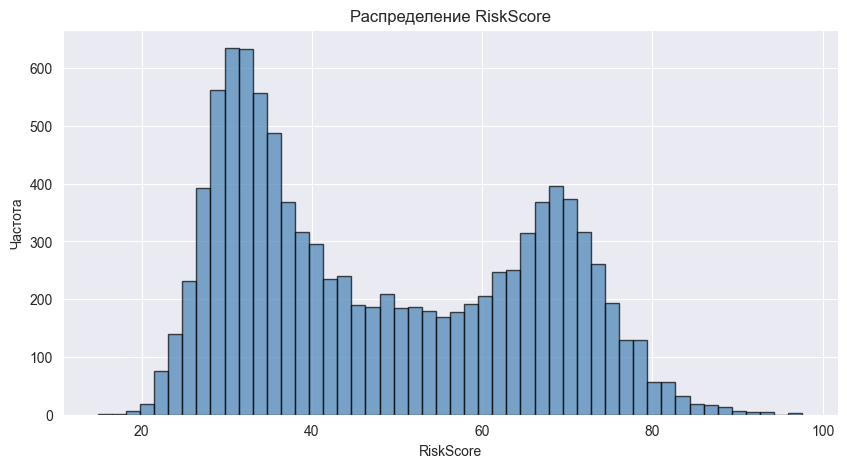

Обработка группы A: CreditScore < 800
Обработка группы B: 800 <= CreditScore < 850
Обработка группы C: CreditScore == 850

🔍 Кросс-валидация:
  Группа A (<800): alpha=1, MSE=49.33
  Группа B (800-849): alpha=1, MSE=36.34
  Группа C (=850): alpha=1, MSE=30.17

✅ Финальная модель завершена!
  Пример предсказаний:
   ID  RiskScore
0   0  32.405511
1   1  52.839975
2   2  26.875569
3   3  35.229267
4   4  37.438738

🎯 Ожидаемый общий MSE: 42.44


In [70]:
# -*- coding: utf-8 -*-
"""
Three-Stage Linear Regression with Advanced Feature Engineering
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import KFold
from scipy.stats import mstats

# -----------------------------
# 1. Загрузка и визуализация
# -----------------------------
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_ids = test_df['ID'].copy()

train_vis = train_df[
    (train_df['RiskScore'] != -9999999) &
    (train_df['RiskScore'] != 10000000) &
    (train_df['RiskScore'] >= 0) &
    (train_df['RiskScore'] <= 100)
].copy()

plt.figure(figsize=(10, 5))
plt.hist(train_vis['RiskScore'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.title('Распределение RiskScore')
plt.grid(True)
plt.show()

# -----------------------------
# 2. Подготовка данных и ТРИ группы
# -----------------------------
clean_mask = (
    (train_df['RiskScore'] != -9999999) &
    (train_df['RiskScore'] != 10000000) &
    (train_df['RiskScore'] >= 0) &
    (train_df['RiskScore'] <= 100)
)
train_clean = train_df[clean_mask].copy()
y_all = train_clean['RiskScore'].values
train_clean = train_clean.drop(columns=['RiskScore'])

mask_A = (train_clean['CreditScore'] < 800)
mask_B = (train_clean['CreditScore'] >= 800) & (train_clean['CreditScore'] < 850)
mask_C = (train_clean['CreditScore'] == 850)

train_A, train_B, train_C = train_clean[mask_A].copy(), train_clean[mask_B].copy(), train_clean[mask_C].copy()
y_A, y_B, y_C = y_all[mask_A], y_all[mask_B], y_all[mask_C]

test_A = test_df[test_df['CreditScore'] < 800].copy()
test_B = test_df[(test_df['CreditScore'] >= 800) & (test_df['CreditScore'] < 850)].copy()
test_C = test_df[test_df['CreditScore'] == 850].copy()

# -----------------------------
# 3. Улучшенная функция предобработки
# -----------------------------
def preprocess_group(df_train, df_test, y_train=None, group_name=""):
    def preprocess_group(df_train, df_test, y_train=None, group_name=""):
    for df in [df_train, df_test]:
        df.drop(columns=['ID'], errors='ignore', inplace=True)

    # Базовые утечки — удаляем всегда
    base_to_drop = [
        'ApplicationDate', 'MonthlyLoanPayment', 'InterestRate',
        'BaseInterestRate', 'TotalDebtToIncomeRatio',
        'NetWorth', 'TotalAssets'
    ]
    df_train.drop(columns=base_to_drop, errors='ignore', inplace=True)
    df_test.drop(columns=base_to_drop, errors='ignore', inplace=True)

    # === ГРУППО-СПЕЦИФИЧНЫЕ ПРИЗНАКИ ===
    if group_name == "C":  # CreditScore = 850
        # Удаляем CreditScore — он константа и не информативен!
        if 'CreditScore' in df_train.columns:
            df_train.drop(columns=['CreditScore'], inplace=True)
            df_test.drop(columns=['CreditScore'], inplace=True)
        # Можно также удалить сильно коррелирующие признаки

    elif group_name == "A":  # CreditScore < 800
        # Оставляем всё, но добавляем специфичные признаки
        pass  # (ничего не удаляем)




    # === ОСНОВНЫЕ КВАДРАТИЧНЫЕ ПРИЗНАКИ ===
    if 'CreditScore' in df_train.columns:
        df_train['CreditScore_IsMax'] = (df_train['CreditScore'] == 850).astype(int)
        df_test['CreditScore_IsMax'] = (df_test['CreditScore'] == 850).astype(int)

        mean_cs = df_train['CreditScore'].mean()
        df_train['CreditScore_centered'] = df_train['CreditScore'] - mean_cs
        df_test['CreditScore_centered'] = df_test['CreditScore'] - mean_cs
        df_train['CreditScore_sq'] = df_train['CreditScore_centered'] ** 2
        df_test['CreditScore_sq'] = df_test['CreditScore_centered'] ** 2

        # Флаг для низкого CreditScore (улучшение для группы A)
        df_train['CreditScore_Low'] = (df_train['CreditScore'] < 600).astype(int)
        df_test['CreditScore_Low'] = (df_test['CreditScore'] < 600).astype(int)

    # === ДОПОЛНИТЕЛЬНЫЕ НЕЛИНЕЙНЫЕ ПРИЗНАКИ ===
    if 'DebtToIncomeRatio' in df_train.columns:
        mean_dti = df_train['DebtToIncomeRatio'].mean()
        df_train['DebtToIncomeRatio_centered'] = df_train['DebtToIncomeRatio'] - mean_dti
        df_test['DebtToIncomeRatio_centered'] = df_test['DebtToIncomeRatio'] - mean_dti
        df_train['DebtToIncomeRatio_sq'] = df_train['DebtToIncomeRatio_centered'] ** 2
        df_test['DebtToIncomeRatio_sq'] = df_test['DebtToIncomeRatio_centered'] ** 2

    if 'AnnualIncome' in df_train.columns:
        df_train['Log_AnnualIncome'] = np.log1p(df_train['AnnualIncome'])
        df_test['Log_AnnualIncome'] = np.log1p(df_test['AnnualIncome'])

    # === ИНТЕРАКТИВНЫЕ ПРИЗНАКИ ===
    if 'AnnualIncome' in df_train.columns and 'DebtToIncomeRatio' in df_train.columns:
        df_train['Income_x_Debt'] = df_train['AnnualIncome'] * df_train['DebtToIncomeRatio']
        df_test['Income_x_Debt'] = df_test['AnnualIncome'] * df_test['DebtToIncomeRatio']

    if 'CreditScore' in df_train.columns and 'BankruptcyHistory' in df_train.columns:
        df_train['CS_x_Bankrupt'] = df_train['CreditScore'] * df_train['BankruptcyHistory']
        df_test['CS_x_Bankrupt'] = df_test['CreditScore'] * df_test['BankruptcyHistory']

    if 'AnnualIncome' in df_train.columns and 'NumberOfDependents' in df_train.columns:
        df_train['IncomePerDep'] = df_train['AnnualIncome'] / (df_train['NumberOfDependents'] + 1)
        df_test['IncomePerDep'] = df_test['AnnualIncome'] / (df_test['NumberOfDependents'] + 1)

    # Заполнение пропусков
    for col in df_train.columns:
        if df_train[col].dtype in [np.float64, np.int64]:
            mean_val = df_train[col].mean()
            df_train[col].fillna(mean_val, inplace=True)
            df_test[col].fillna(mean_val, inplace=True)
        else:
            mode_val = df_train[col].mode()
            fill_val = mode_val[0] if not mode_val.empty else 'Unknown'
            df_train[col].fillna(fill_val, inplace=True)
            df_test[col].fillna(fill_val, inplace=True)

    # One-Hot
    cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()
    df_train = pd.get_dummies(df_train, columns=cat_cols, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=cat_cols, drop_first=True)

    # Выравнивание
    common_cols = df_train.columns.intersection(df_test.columns)
    df_train = df_train[common_cols]
    df_test = df_test[common_cols]
    for col in df_train.columns:
        if col not in df_test.columns:
            df_test[col] = 0
    df_test = df_test[df_train.columns]

    # Удаляем MonthlyIncome
    if 'MonthlyIncome' in df_train.columns:
        df_train.drop(columns=['MonthlyIncome'], inplace=True)
        df_test.drop(columns=['MonthlyIncome'], inplace=True)

    # Обработка выбросов
    for col in ['AnnualIncome', 'DebtToIncomeRatio']:
        if col in df_train.columns:
            df_train[col] = mstats.winsorize(df_train[col], limits=[0.0, 0.02])
            df_test[col] = mstats.winsorize(df_test[col], limits=[0.0, 0.02])

    # Преобразование
    X_train = df_train.values.astype(np.float64)
    X_test = df_test.values.astype(np.float64)
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)

    # Нормализация: StandardScaler для группы A, RobustScaler для B/C
    if group_name == "A":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    return X_train_norm, X_test_norm, y_train

# -----------------------------
# 4. Обработка групп с указанием имени
# -----------------------------
print("Обработка группы A: CreditScore < 800")
X_A_train, X_A_test, _ = preprocess_group(train_A, test_A, y_A, group_name="A")

print("Обработка группы B: 800 <= CreditScore < 850")
X_B_train, X_B_test, _ = preprocess_group(train_B, test_B, y_B, group_name="B")

print("Обработка группы C: CreditScore == 850")
X_C_train, X_C_test, _ = preprocess_group(train_C, test_C, y_C, group_name="C")

# -----------------------------
# 5. Ridge-регрессия (без изменений)
# -----------------------------
class RidgeRegression:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.w = None
        self.b = 0.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X_b = np.c_[np.ones(n_samples), X]
        I = np.eye(n_features + 1)
        I[0, 0] = 0
        try:
            theta = np.linalg.inv(X_b.T @ X_b + self.alpha * I) @ X_b.T @ y
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T @ X_b + self.alpha * I) @ X_b.T @ y
        self.b, self.w = theta[0], theta[1:]

    def predict(self, X):
        return X @ self.w + self.b

def cross_val_mse(X, y, alpha, k=5):
    if len(y) <= k:
        k = min(2, len(y))
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        model = RidgeRegression(alpha=alpha)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(np.mean((y_val - y_pred) ** 2))
    return np.mean(scores), np.std(scores)

def select_best_alpha(X_train, y_train, alphas, group_name):
    if len(y_train) == 0:
        print(f"  ⚠️  Группа {group_name} пуста")
        return None, None
    best_alpha, best_mse = None, float('inf')
    for alpha in alphas:
        mse_val, _ = cross_val_mse(X_train, y_train, alpha, k=min(5, len(y_train)))
        if mse_val < best_mse:
            best_mse, best_alpha = mse_val, alpha
    print(f"  Группа {group_name}: alpha={best_alpha}, MSE={best_mse:.2f}")
    return best_alpha, best_mse

# -----------------------------
# 6. Подбор alpha с расширенным диапазоном для группы A
# -----------------------------
print("\n🔍 Кросс-валидация:")
best_alpha_A, best_mse_A = select_best_alpha(X_A_train, y_A, [0.01, 0.05, 0.1, 0.5, 1, 2, 5], "A (<800)")
best_alpha_B, best_mse_B = select_best_alpha(X_B_train, y_B, [0.1, 1, 5, 10, 20, 50], "B (800-849)")
best_alpha_C, best_mse_C = select_best_alpha(X_C_train, y_C, [1, 5, 10, 20, 50, 100, 200], "C (=850)")

# -----------------------------
# 7. Финальное предсказание
# -----------------------------
y_test_pred = np.full(len(test_df), np.nan)

if best_alpha_A is not None and len(X_A_test) > 0:
    model_A = RidgeRegression(alpha=best_alpha_A)
    model_A.fit(X_A_train, y_A)
    pred_A = model_A.predict(X_A_test)
    idx_A = test_df[test_df['CreditScore'] < 800].index
    y_test_pred[idx_A] = pred_A

if best_alpha_B is not None and len(X_B_test) > 0:
    model_B = RidgeRegression(alpha=best_alpha_B)
    model_B.fit(X_B_train, y_B)
    pred_B = model_B.predict(X_B_test)
    idx_B = test_df[(test_df['CreditScore'] >= 800) & (test_df['CreditScore'] < 850)].index
    y_test_pred[idx_B] = pred_B

if best_alpha_C is not None and len(X_C_test) > 0:
    model_C = RidgeRegression(alpha=best_alpha_C)
    model_C.fit(X_C_train, y_C)
    pred_C = model_C.predict(X_C_test)
    idx_C = test_df[test_df['CreditScore'] == 850].index
    y_test_pred[idx_C] = pred_C

y_test_pred = np.nan_to_num(y_test_pred, nan=np.mean(y_all))
y_test_pred = np.clip(y_test_pred, 0, 100)

# -----------------------------
# 8. Сохранение и вывод
# -----------------------------
submission = pd.DataFrame({'ID': test_ids, 'RiskScore': y_test_pred})
submission.to_csv('submission_final.csv', index=False)

print(f"\n✅ Финальная модель завершена!")
print(f"  Пример предсказаний:\n{submission.head()}")

# Ожидаемый MSE
if all(m is not None for m in [best_mse_A, best_mse_B, best_mse_C]):
    total = len(y_A) + len(y_B) + len(y_C)
    weighted_mse = (len(y_A)*best_mse_A + len(y_B)*best_mse_B + len(y_C)*best_mse_C) / total
    print(f"\n🎯 Ожидаемый общий MSE: {weighted_mse:.2f}")